# Recommender System

Blah blah blah

## Import Libraries and Define File Paths

In [28]:
import scipy
import random
import pandas as pd
import numpy as np
import threadpoolctl
from collections import defaultdict
from implicit.als import AlternatingLeastSquares as ALS
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate, train_test_split, KFold
from surprise.prediction_algorithms.knns import KNNBasic, KNNWithMeans
from surprise.prediction_algorithms.matrix_factorization import SVD
from implicit.evaluation import (AUC_at_k,
                                 mean_average_precision_at_k,
                                 ndcg_at_k, precision_at_k)
from implicit.evaluation import train_test_split
import matplotlib.pyplot as plt

dir = "../dataset/utility"

def load_dataset():
    items_df = pd.read_csv(f"{dir}/itemset_preprocessed.csv")
    items_df.set_index("ASIN", inplace=True)
 
    df_utility = pd.read_csv(f"{dir}/utility_topn.csv")
    df_utility.set_index("reviewerID", inplace=True)

    reviews_df = pd.read_csv(f"{dir}/reviews.csv")
    reviews_df = reviews_df.replace(np.nan, '', regex=True)
    reviews_df.set_index('reviewerID', inplace=True)
    
    asins_df = pd.read_csv(f"{dir}/asin_product_mapping.csv")

    print(f"shape of df_utility: {df_utility.shape}")
    print(f"shape of items_df: {items_df.shape}")
    print(f"shape of asins_df: {asins_df.shape}")
    return items_df, df_utility, reviews_df, asins_df

## Load Dataset

In [29]:
items_df, df_utility, reviews_df, asins_df = load_dataset()

shape of df_utility: (445, 33510)
shape of items_df: (33554, 2430)
shape of asins_df: (36059, 2)


In [30]:
display(items_df)
display(df_utility)
display(reviews_df)
display(asins_df)

,customerReview,brand,toys,games,toy,figures,playsets,action,dolls,accessories,...,clogs,ballet,wedges,heeled,tights,shrugs,bras,workout,bottom,bodysuits
ASIN,,,,,,,,,,,,,,,,,,,,,
b001f30182,4.7,starwars,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
b001gn794k,4.7,mcfarlanetoys,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
b00askv7fe,4.7,spiderman,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
b00hzsmwmy,4.7,accoutrements,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
b00ik8qpoy,4.7,marvel,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b07zt8vlv4,4.2,bestisun,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
b0cqy9mrmr,4.7,maxbee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
b0cjr8rplq,4.4,towncat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,b001f30182,b001gn794k,b00askv7fe,b00hzsmwmy,b00ik8qpoy,b00wo0adqk,b011miv3eu,b01jcuyul8,b07d8f6cn5,b07dfbjr78,...,b0cp3cxqj7,b0cp5cwv1k,b0b7rf4hkm,b0cphcrsrg,b09gnz9hp3,b07zt8vlv4,b0cqy9mrmr,b0cjr8rplq,b0cr15gpvh,b0cszbnwtw
reviewerID,,,,,,,,,,,,,,,,,,,,,
***Toy Collector***_AG5NFKDKQNEYV76GKH7BMXNTHKSQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A._,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AJ_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aaron_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
dac_AHK2DUBBBFRGDSNKJG6CQA7AT3OA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
live love laugh_AGEJVATBEAWO46BMRZTXDTIANJFQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mike_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,ASIN,ProductName,reviewRating,reviewDate,reviewLocation,reviewVotes
reviewerID,,,,,,
TK-815TK-815_AH4NM3KGMDME7SKRSJD73TIBABIQ,b001f30182,star_wars_the_black_series_dark_trooper_toy_6i...,5.0,"September 21, 2022",United States,13
vyeranos_AESWEZHPRRYTZRW2FBIJSXEKGTFA,b001f30182,star_wars_the_black_series_dark_trooper_toy_6i...,5.0,"January 13, 2024",United States,0
Marty_AHGIPPEB6HKSXNPB6Y3DLBKCVRHQ,b001f30182,star_wars_the_black_series_dark_trooper_toy_6i...,5.0,"November 24, 2023",United States,0
Kati_AHWQ73WR7MVGBKDB5YE6C4WDPNJA,b001f30182,star_wars_the_black_series_dark_trooper_toy_6i...,5.0,"January 2, 2024",United States,0
Lochlan LongstriderLochlan Longstrider_AHSHUIZHSPWYY3OD3PI56MSBKZ4Q,b001f30182,star_wars_the_black_series_dark_trooper_toy_6i...,4.0,"September 18, 2023",United States,0
...,...,...,...,...,...,...
Amazon CustomerAmazon Customer_AG52QM7OQDTBA4PS7FE4YBCXSOWA,b0cr15gpvh,aurola_serpent_seamless_scrunch_workout_shorts...,4.0,"February 4, 2024",United States,0
Jenny Woods_AEO3O5NXXEBNIGTFD2NYQBH6V4JA,b0cr15gpvh,aurola_serpent_seamless_scrunch_workout_shorts...,4.0,"February 10, 2024",United States,0
Reviews!Reviews!_AGBE2PKD6HCB7S4I4FWGQDLM626A,b0cr15gpvh,aurola_serpent_seamless_scrunch_workout_shorts...,5.0,"February 6, 2024",United States,0


,ASIN,name
0,b001f30182,STAR WARS The Black Series Dark Trooper Toy 6-...
1,b001gn794k,"Avatar: The Last Airbender Prince Zuko 7"" Acti..."
2,b00askv7fe,Hasbro Marvel Ultimate Spider-man Titan Hero S...
3,b00hzsmwmy,Accoutrements Crazy Cat Lady Action Figure Mul...
4,b00ik8qpoy,Marvel Ultimate Spider-Man Titan Hero Series A...
...,...,...
36054,b0cqy9mrmr,Maxbee Flared Leggings with Pockets for Women ...
36055,b0cjr8rplq,"TownCat Women’s Yoga Pants with Pockets, High ..."
36056,b0cr15gpvh,AUROLA Serpent Seamless Scrunch Workout Shorts...
36057,b0cskr8rj5,Spyder Men's Active Shirt - Fitted Short Sleev...


## One Hot Encode the "brand" column

In [31]:
items_df = pd.get_dummies(items_df, columns=['brand'], dtype='float')

In [32]:
items_df

,customerReview,toys,games,toy,figures,playsets,action,dolls,accessories,building,...,brand_zyflsq,brand_zyhoone,brand_zyliss,brand_zyyini,brand_zzb,brand_zzenrysam,brand_zzjmch,brand_zzranye,brand_zzrywuty,brand_zzwhom
ASIN,,,,,,,,,,,,,,,,,,,,,
b001f30182,4.7,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
b001gn794k,4.7,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
b00askv7fe,4.7,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
b00hzsmwmy,4.7,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
b00ik8qpoy,4.7,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b07zt8vlv4,4.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
b0cqy9mrmr,4.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
b0cjr8rplq,4.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Try all algorithms
* Neighborhood-based collaborative filtering
* Latent-factor based collaborative filtering
* Content-based collaborative filtering

## Neighborhood-based Collaborative Filtering

From Surprise

In [33]:
melted_user_df = df_utility.copy().reset_index().melt(
    'reviewerID', var_name='ASIN', value_name='rating').dropna()
reader = Reader(rating_scale=(0,5))
dataset = Dataset.load_from_df(melted_user_df, reader)
algos = [KNNBasic(), KNNWithMeans(), SVD()]

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


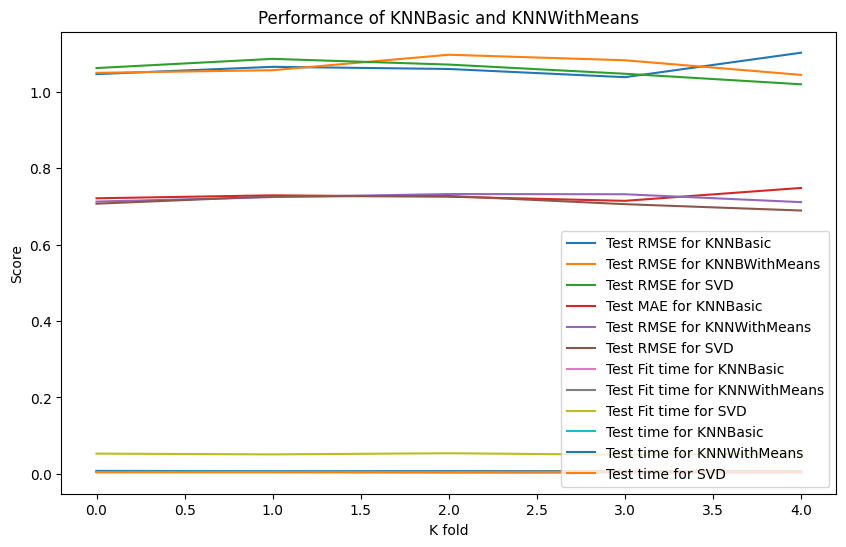

In [34]:
metrics_list = []
for algo in algos:
    metrics = cross_validate(algo, dataset)
    metrics['mean_test_rmse'] = np.mean(metrics['test_rmse'])
    metrics['mean_test_mae'] = np.mean(metrics['test_mae'])
    metrics_list.append(metrics)


k = range(0,5)
plt.figure(figsize=(10, 6))
plt.plot(k, metrics_list[0]['test_rmse'], label='Test RMSE for KNNBasic')
plt.plot(k, metrics_list[1]['test_rmse'], label='Test RMSE for KNNBWithMeans')
plt.plot(k, metrics_list[2]['test_rmse'], label='Test RMSE for SVD')
plt.plot(k, metrics_list[0]['test_mae'], label='Test MAE for KNNBasic')
plt.plot(k, metrics_list[1]['test_mae'], label='Test RMSE for KNNWithMeans')
plt.plot(k, metrics_list[2]['test_mae'], label='Test RMSE for SVD')
plt.plot(k, metrics_list[0]['fit_time'], label='Test Fit time for KNNBasic')
plt.plot(k, metrics_list[1]['fit_time'], label='Test Fit time for KNNWithMeans')
plt.plot(k, metrics_list[2]['fit_time'], label='Test Fit time for SVD')
plt.plot(k, metrics_list[0]['test_time'], label='Test time for KNNBasic')
plt.plot(k, metrics_list[1]['test_time'], label='Test time for KNNWithMeans')
plt.plot(k, metrics_list[2]['test_time'], label='Test time for SVD')
plt.xlabel("K fold")
plt.ylabel("Score")
plt.legend(loc='lower right')
plt.title("Performance of KNNBasic and KNNWithMeans")
plt.show()

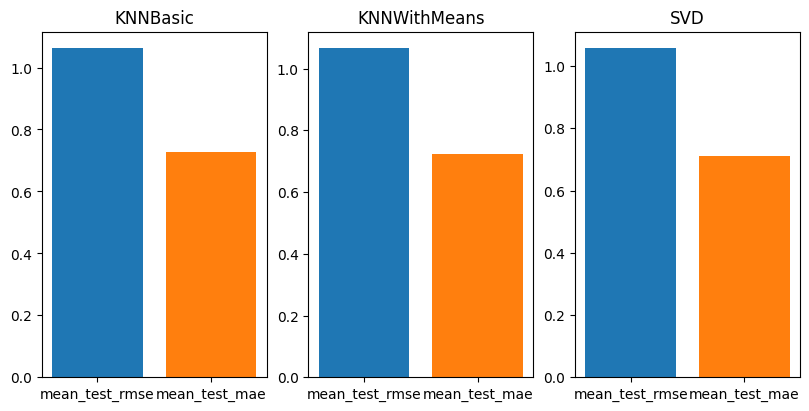

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(8,4), layout='constrained')
method = ["KNNBasic", "KNNWithMeans", "SVD"]
ind = 0
for m in metrics_list:
    for k in m:
        if 'mean' in k:
            axes[ind].bar(k, m[k])
            axes[ind].set_title(method[ind])
    ind += 1
plt.show()

### Precision and Recall

Taken from https://github.com/NicolasHug/Surprise/blob/master/examples/precision_recall_at_k.py

In [36]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

kf = KFold(n_splits=5)

algo_res = []
for algo in algos:
    print(f"computing precision and recall for {algo}")
    res_dict = {'precision': [], 'recall': []}
    for trainset, testset in kf.split(dataset):
        algo.fit(trainset)
        predictions = algo.test(testset)
        precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)
        res_dict['precision'].append(sum(prec for prec in precisions.values()) / len(precisions))
        res_dict['recall'].append(sum(rec for rec in recalls.values()) / len(recalls))
    algo_res.append(res_dict)

computing precision and recall for <surprise.prediction_algorithms.knns.KNNBasic object at 0x00000213E88329D0>
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
computing precision and recall for <surprise.prediction_algorithms.knns.KNNWithMeans object at 0x00000213E88333D0>
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
computing precision and recall for <surprise

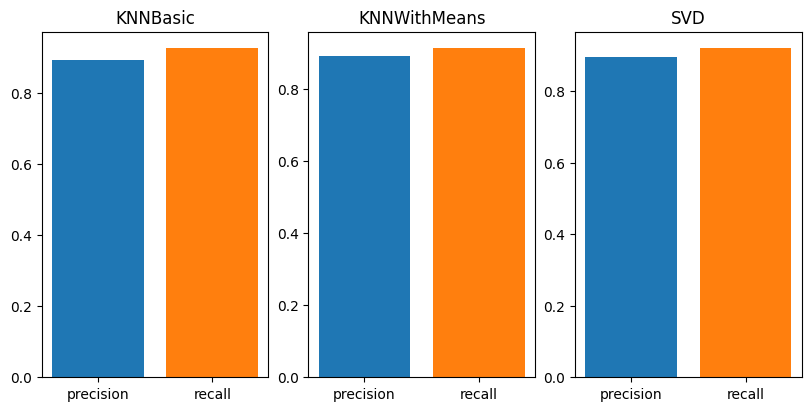

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(8,4), layout='constrained')
method = ["KNNBasic", "KNNWithMeans", "SVD"]
ind = 0
for m in algo_res:
    for k in m:
        axes[ind].bar(k, m[k])
        axes[ind].set_title(method[ind])
    ind += 1
plt.show()

### Get TopN Recommendations for a user

Taken from https://github.com/NicolasHug/Surprise/blob/master/examples/top_n_recommendations.py

In [38]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algos[2].test(testset) # SVD

top_n = get_top_n(predictions, n=10)

# Get the recommended items for each user
recommendations = {}
for uid, user_ratings in top_n.items():
    recommendations[uid] = [iid for (iid, _) in user_ratings]

### Pick out users and explore their history and recommendations

Use SVD because KNN sucks

In [42]:
asins_df.set_index('ASIN', inplace=True)

In [43]:
def show_user_history_and_recos(recommendations, user_id):
    """
    Display user purchase history and recommendations
    """
    display(reviews_df.loc[[user_id]][['ProductName', 'reviewRating']])
    reco_list = recommendations[user_id]
    print("recommended items")
    display(asins_df.loc[reco_list])
    print('\n')

In [45]:
user_ids = [x for x in list(recommendations.keys()) if len(x.split('_')[-1]) > 1][:5]
for user_id in user_ids:
    show_user_history_and_recos(recommendations, user_id)

,ProductName,reviewRating
reviewerID,,
Harry _AELUZ4IIDBETBOOHUO6IOFX7EXTA,queen_size_4_piece_sheet_set__comfy_breathable...,5.0
Harry _AELUZ4IIDBETBOOHUO6IOFX7EXTA,pink_king_size_quilt_bedding_sets_with_pillow_...,5.0
Harry _AELUZ4IIDBETBOOHUO6IOFX7EXTA,powerbear_4k_hdmi_cable_10_ft_|_high_speed_hdm...,5.0
Harry _AELUZ4IIDBETBOOHUO6IOFX7EXTA,native_deodorant_contains_naturally_derived_in...,5.0
Harry _AELUZ4IIDBETBOOHUO6IOFX7EXTA,native_deodorant_contains_naturally_derived_in...,5.0
Harry _AELUZ4IIDBETBOOHUO6IOFX7EXTA,queen_size_4_piece_sheet_set__comfy_breathable...,5.0
Harry _AELUZ4IIDBETBOOHUO6IOFX7EXTA,spiral_notebook__3_pack_a5_spiral_notebooks_59...,5.0
Harry _AELUZ4IIDBETBOOHUO6IOFX7EXTA,bed_pillows_for_sleeping_medium_firm_queen_siz...,5.0
Harry _AELUZ4IIDBETBOOHUO6IOFX7EXTA,cooling_pillows_queen_size_set_of_2_memory_foa...,5.0


recommended items


,name
ASIN,
b0cn7d2sm4,MEWOW Women's Winter Mid Length Thick Warm Fau...
b07wlk54t6,Moerie Ultimate Hair Growth Shampoo – For Long...
b0br8l2f14,The September House
b07q2sx3mr,Dreamer Car Wedge Seat Cushion for Car Seat Dr...
1626926832,Grimgar of Fantasy and Ash (Light Novel) Vol. 5
b0c35lt2mn,"e.l.f. Halo Glow Highlight Beauty Wand, Liquid..."
b0brzd1kvb,"60132 Balaclava, Warm Breathable Fleece Wind P..."
b015zzwm1y,Calphalon Nonstick Frying Pan with Stay-Cool H...
b00ht6e522,Playtex Sport Tampons with Flex-Fit Technology...


,ProductName,reviewRating
reviewerID,,
live love laugh_AGEJVATBEAWO46BMRZTXDTIANJFQ,amazon_elements_baby_wipes_sensitive_fragrance...,5.0
live love laugh_AGEJVATBEAWO46BMRZTXDTIANJFQ,tide_hygienic_clean_heavy_10x_duty_laundry_det...,5.0
live love laugh_AGEJVATBEAWO46BMRZTXDTIANJFQ,washing_machine_cleaner_descaler_24_pack__deep...,5.0
live love laugh_AGEJVATBEAWO46BMRZTXDTIANJFQ,dishwasher_cleaner_and_deodorizer_tablets__24_...,5.0
live love laugh_AGEJVATBEAWO46BMRZTXDTIANJFQ,washing_machine_and_dishwasher_cleaning_tablet...,5.0
live love laugh_AGEJVATBEAWO46BMRZTXDTIANJFQ,care_science_fabric_adhesive_bandages_200_ct_b...,5.0
live love laugh_AGEJVATBEAWO46BMRZTXDTIANJFQ,diy_shoe_rack_8_tier_shoe_organizer_for_closet...,5.0
live love laugh_AGEJVATBEAWO46BMRZTXDTIANJFQ,kleenex_expressions_ultra_soft_facial_tissues_...,5.0
live love laugh_AGEJVATBEAWO46BMRZTXDTIANJFQ,angel_soft_toilet_paper_16_mega_rolls,5.0


recommended items


,name
ASIN,
b000gcnblw,"Tampax Cardboard Applicator Tampons, Regular, ..."
b0cn7d2sm4,MEWOW Women's Winter Mid Length Thick Warm Fau...
b0cryv6fjh,Beneath the Beastly Duke's Mask: A Historical ...
b09gnz9hp3,NEW YOUNG 3 Pack Leggings with Pockets for Wom...
b08cbp49ks,Cole Haan Men's Grand Crosscourt Modern Perfor...
b0cqvsjmpc,Bride of the Western Dawn: A Historical Wester...
b07b4z9l7m,Amazon Basics Lightweight Super Soft Easy Care...
b0c49s1jmz,Dokotoo Womens Ladies Ribbed Thick Strap Racer...
b001oab6bw,Metra 72-5600 Ford Speaker Harness 1998-UP


,ProductName,reviewRating
reviewerID,,
Penny Lane_AGH62UUHMMOSEJPZP3DBQN67WW5A,baby_wipes_unscented_by_boogie_wipes_wet_wipes...,5.0
Penny Lane_AGH62UUHMMOSEJPZP3DBQN67WW5A,2_pack_aux_cableauxiliary_cable16ft/05m_hifi_s...,5.0
Penny Lane_AGH62UUHMMOSEJPZP3DBQN67WW5A,bubble_bum_inflatable_travel_portable_booster_...,5.0
Penny Lane_AGH62UUHMMOSEJPZP3DBQN67WW5A,amazon_essentials_women's_lightweight_waterres...,5.0
Penny Lane_AGH62UUHMMOSEJPZP3DBQN67WW5A,scotchbrite_dishwand_brush_scrubber_for_cleani...,5.0
Penny Lane_AGH62UUHMMOSEJPZP3DBQN67WW5A,cosrx_snail_mucin_96%_power_repairing_essence_...,5.0
Penny Lane_AGH62UUHMMOSEJPZP3DBQN67WW5A,mario_badescu_setting_facial_spray_mist_with_a...,5.0
Penny Lane_AGH62UUHMMOSEJPZP3DBQN67WW5A,eywamage_grey_glass_flameless_candles_with_rem...,5.0
Penny Lane_AGH62UUHMMOSEJPZP3DBQN67WW5A,serwalin_pampas_grass_decor_white_177_inch_6pc...,5.0


recommended items


,name
ASIN,
b08jd5pv9f,Kingston DataTraveler Exodia 64GB USB 3.2 Flas...
b07tbg7wm9,"Yilador Webcam Cover (3 Pack), 0.03 inch Ultra..."
b0bz2crw8h,Corsair HX1000i Fully Modular Ultra-Low Noise ...
b014yn7lve,NETGEAR Wi-Fi Range Extender EX6120 - Coverage...
b086tsj1n1,Primula Burke Deluxe Cold Brew Iced Coffee Mak...
b016civheg,eBags Classic 4 Piece Packing Cube Set
b09dypt6ld,"amFilm OneTouch Compatible with iPhone 14 6.1""..."
b0c7c1qcym,"Reyee AX3000 Wi-Fi 6 Router, Dual Band Interne..."
b0cqg6b1h2,"Aveniee Clear Makeup Bag Small, Travel Toiletr..."


,ProductName,reviewRating
reviewerID,,
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,gerber_snacks_for_baby_lil_crunchies_mild_ched...,5.0
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,energizer_max_c_batteries_premium_alkaline_c_c...,5.0
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,ocedar_powercorner_one_sweep_broom_with_stepon...,5.0
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,ocedar_pet_pro_broom_stepon_dustpan_powercorne...,5.0
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,"oxo_good_grips_pro_10""_frying_pan_skillet_3lay...",5.0
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,corsair_rm1000x_2021_fully_modular_atx_power_s...,5.0
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,seagate_barracuda_8tb_internal_hard_drive_hdd_...,5.0
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,intel_core_i513600k_desktop_processor_14_6_pco...,5.0
Steven_AHPRRIDI7LA42GJZ7OKWELQPNOIQ,libman_2011_nitty_gritty_roller_mop_refill,5.0


recommended items


,name
ASIN,
b0ccq7dnql,Google Pixel Watch 2 with the Best of Fitbit a...
b00leh3lze,Silicon Power 1TB Armor A60 Shockproof Portabl...
b0ckfpgtzv,NatureWise Vitamin D3 2000iu (50 mcg) Healthy ...
b0c3h1nlxk,Full Bed Frame with Storage Headboard Metal Pl...
b00jlaop3s,Flat Top Kabuki Foundation Brush By KESHIMA - ...
b012w9bi2k,Joseph Joseph M-Cuisine Microwave Rice Cooker ...
b0cc4m1jgp,"LENNYVILLNA Dresser for Bedroom, Tall Dresser ..."
b0cfvg3yqd,"Etercycle Toiletry Bag for Women Men, Waterpro..."
b08br6xlbt,"INPHIC Mouse, 3 Modes Bluetooth 5.0&4.0 Mouse ..."


,ProductName,reviewRating
reviewerID,,
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,romitaz_iphone_fast_charger_lightning_cable_[a...,5.0
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,wantdo_men's_wool_blend_jacket_stand_collar_wi...,3.0
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,cooler_master_masterliquid_ml240l_v2_rgb_cpu_l...,5.0
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,no_918_erica_crushed_sheer_voile_rod_pocket_cu...,5.0
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,no_918_emily_sheer_voile_rod_pocket_curtain_pa...,5.0
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,sun_zero_barrow_energy_efficient_rod_pocket_cu...,4.0
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,dash_cam_front_and_rear_chortau_dual_dash_cam_...,5.0
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,tide_hygienic_clean_heavy_duty_10x_free_power_...,5.0
John_AG6PIPVFXVM2UIU2LKEGND4SN6GQ,biore_deep_pore_charcoal_face_wash_facial_clea...,5.0


recommended items


,name
ASIN,
0399589015,Zero Fail: The Rise and Fall of the Secret Ser...
b08qbslcd6,Men's Iconic Fashion 3 Pack Cotton Stretch Box...
b00leh3lze,Silicon Power 1TB Armor A60 Shockproof Portabl...
b07bz6t96p,icyzone Women's Racerback Workout Athletic Run...
077831197x,The Lost Apothecary: A Novel
b07bkhhl16,The Body Shop Maca Root & Aloe Softening Shavi...
b015zzwm1y,Calphalon Nonstick Frying Pan with Stay-Cool H...
b073jznp18,Sourdough: A Novel
b08cbp49ks,Cole Haan Men's Grand Crosscourt Modern Perfor...


## Latent-factor based Collaborative Filtering

### ALS

shape of df_utility: (445, 33510)
shape of items_df: (33554, 2430)
shape of asins_df: (36059, 2)


'export' is not recognized as an internal or external command,
operable program or batch file.
100%|██████████| 394/394 [00:00<00:00, 4923.89it/s]


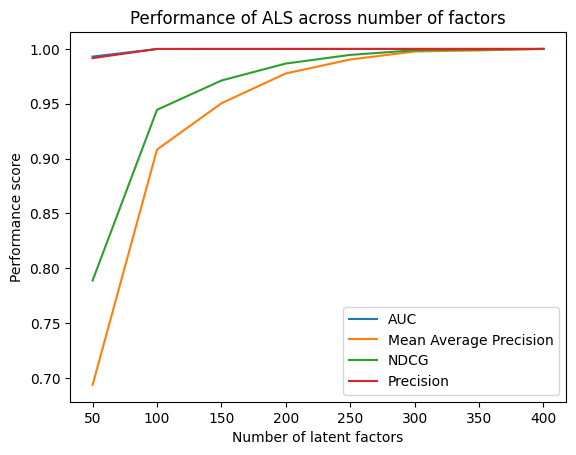

In [46]:
items_df, df_utility, reviews_df, items_with_info_df = load_dataset()
csr_utility = scipy.sparse.csr_matrix(df_utility.fillna(0).values)
!export OPENBLAS_NUM_THREADS=1
threadpoolctl.threadpool_limits(1, "blas")

auc_list = []
mean_ave_precision_list = []
ndcg_list = []
precision_list = []

factors = [50, 100, 150, 200, 250, 300,
           350, 400]

for factor in factors:
    model = ALS(
        factors=factor,
        regularization=0.1,
        alpha=1,
        calculate_training_loss=True,
        use_cg=True,
        iterations=15,
        random_state=143
    )
    model.fit(csr_utility)

    # evaluation
    training_set, test_set = train_test_split(
        csr_utility,
        train_percentage=0.85,
        random_state=143
    )
    auc = AUC_at_k(model,training_set,test_set,
                K=len(df_utility), show_progress=True)
    mean_ave_precision = mean_average_precision_at_k(model, training_set,
                test_set, K=len(df_utility), show_progress=True)
    ndcg = ndcg_at_k(model, training_set, test_set,
                K=len(df_utility), show_progress=True)
    precision = precision_at_k(model, training_set,
                test_set, K=len(df_utility), show_progress=True)
    auc_list.append(auc)
    mean_ave_precision_list.append(mean_ave_precision)
    ndcg_list.append(ndcg)
    precision_list.append(precision)

plt.plot(factors, auc_list, label='AUC')
plt.plot(factors, mean_ave_precision_list, label='Mean Average Precision')
plt.plot(factors, ndcg_list, label='NDCG')
plt.plot(factors, precision_list, label='Precision')
plt.xlabel('Number of latent factors')
plt.ylabel('Performance score')
plt.title("Performance of ALS across number of factors")
plt.legend()
plt.show()

In [49]:
model = ALS(
    factors=300,
    regularization=0.1,
    alpha=1,
    calculate_training_loss=True,
    use_cg=True,
    iterations=15,
    random_state=143
)
model.fit(csr_utility)

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:01<00:00,  8.07it/s, loss=0.000174]


In [52]:
userids = random.sample(range(0, len(df_utility)), 10)
ids, scores = model.recommend(userids, csr_utility[userids])
recommendations = [(x, y, z) for x, y, z in zip(userids, ids, scores)]

try:
    reviews_df.set_index('reviewerID', inplace=True)
except:
    pass

def show_user_history_and_recos_als(recommendations, reviews_df, asins_df):
    """
    Display user purchase history and recommendations
    """
    for user_ind, reco_ids, scores in recommendations:
        reviewer_id = df_utility.iloc[user_ind, :].name
        print(f"user history: {reviewer_id}")
        display(reviews_df.loc[reviewer_id][['ProductName', 'reviewRating']])
        print("recommendations")
        display(asins_df.loc[reco_ids])
        print("scores")
        for reco_id, score in zip(reco_ids, scores):
            print((reco_id, score))
        print('\n')
show_user_history_and_recos_als(recommendations, reviews_df, items_with_info_df)

user history: Julie_


,ProductName,reviewRating
reviewerID,,
Julie_,dream_factory_kids_8piece_complete_set_with_be...,5.0
Julie_,lego_creator_3_in_1_pirate_ship_building_set_k...,5.0
Julie_,short_multi_charging_cable_3pack_1ft_multi_cha...,1.0
Julie_,vankor_car_trash_can_for_car_cute_car_trash_ba...,5.0
Julie_,merokeety_women's_winter_long_sleeve_zip_puffe...,5.0
Julie_,[i'm_from]_miniatures_of_rice_toner_mugwort_es...,5.0
Julie_,langtu_membrane_gaming_keyboard_rainbow_led_ba...,5.0
Julie_,bosceos_table_lamps_set_of_2_with_usb_charging...,5.0
Julie_,yarradecor_bedside_lamp_with_usb_a+c_charging_...,5.0


recommendations


,ASIN,name
1094,b0c7hpdydb,"Homedics Air Purifier, 4-in-1 Tower, True HEPA..."
15478,b0byj2pnl8,COOFANDY Men's Cotton Linen Pants Elastic Wais...
24700,b0cngj5w6q,"Video Doorbell Screwdriver, Double-Ended Screw..."
3201,b0cs2w2x8q,"Giantex 8 Cube Bookcase, Freestanding 3-Tier O..."
21724,b0c5b1c743,Philips Avent Ultra Soft Pacifier - 4 x Soft a...
6583,b0cdr7jh9j,STREBITO Precision Screwdriver Set 153 in 1 Sm...
12918,b0chjxhvzm,WD_BLACK 1TB SN770M M.2 2230 NVMe SSD for Hand...
12279,b072mnbc9m,BerryGPS-IMU GPS and 10DOF for The Raspberry P...
19252,b0c3zp533k,ASUS Prime B760-PLUS Intel B760(13th and 12th ...
32754,b0c4gtbx9b,Wooden Spoons for Cooking - 6 Piece Non Stick ...


scores
(1094, 0.1596271)
(15478, 0.15954775)
(24700, 0.1595076)
(3201, 0.15942374)
(21724, 0.15275207)
(6583, 0.12704906)
(12918, 0.12704878)
(12279, 0.12704864)
(19252, 0.12704848)
(32754, 0.12704751)


user history: Anna_


,ProductName,reviewRating
reviewerID,,
Anna_,wwe_randy_orton_elite_collection_action_figure,5.0
Anna_,air_mist_air_freshener_white_jasmine_scent_300ml,5.0
Anna_,dr_brown's_natural_flow_anticolic_options+_nar...,5.0
Anna_,dapple_baby_bottle_soap_dish_soap_refill_baby_...,5.0
Anna_,amazon_essentials_boys_and_toddlers'_polar_fle...,5.0
Anna_,babybjorn_travel_crib_light_silver_one_size,5.0
Anna_,joydeco_100%_blackout_curtains_96_inches_long_...,5.0
Anna_,persil_discs_laundry_detergent_pacs_original_s...,4.0
Anna_,qinsen_womens_square_neck_bodice_dress_long_sl...,4.0


recommendations


,ASIN,name
16417,b01lzv64rk,Best Choice Products 10in Twin Size Dual Layer...
30529,b07mc1tvx9,the toilet: a short story
11387,b0cscrpx1x,Vagisil Maximum Strength Feminine Anti-Itch Cr...
9570,b09d73qsfs,REAHOME 8 Drawer Dresser for Bedroom with Shel...
24756,152344911x,Challenged (A Changing Krysset Novel)
24890,b0cpnhjqgb,Reaper : A Slow Burn MC Romance Novel (The Dev...
25573,b0cjf2lwfr,"1 PC Car Navigation Tempered Film, 9"" Sensitiv..."
21760,b074kq4c85,LeanTravel Compression Packing Cubes for Trave...
14149,b0c7zcywqm,"Portable Steamer for Clothes Steamer, 2 in 1 T..."
21141,b09hstrl87,"Cuisinart TOA-70W AirFryer Oven with Grill,White"


scores
(16417, 0.13032311)
(30529, 0.130322)
(11387, 0.13032137)
(9570, 0.1303213)
(24756, 0.12514113)
(24890, 0.12514071)
(25573, 0.104876004)
(21760, 0.093555264)
(14149, 0.093555234)
(21141, 0.093554996)


user history: Cheryl_


,ProductName,reviewRating
reviewerID,,
Cheryl_,when_the_innocent_avenge:_a_historical_western...,5.0
Cheryl_,molly's_suds_active_wear_laundry_detergent_|_n...,5.0
Cheryl_,joseph_joseph_cleanstore_wallmounted_indoor_du...,5.0
Cheryl_,caldrea_liquid_fabric_softener_plant_derived_h...,5.0
Cheryl_,beautural_steam_iron_for_clothes_with_precisio...,5.0
Cheryl_,dockorio_all_in_one_kitchen_knife_set_with_blo...,5.0
Cheryl_,flawless_airbrush_foundation_high_coverage_fou...,3.0
Cheryl_,maliton_toiletry_bag_for_men_women_|_large_for...,5.0
Cheryl_,devoted_creations_collagenetics_spa_restorativ...,5.0


recommendations


,ASIN,name
8083,b0bqj738f6,"Rolanstar Corner Desk, 44.5"" W x 34.5"" H Small..."
24594,b0bw97j5mw,Ayotu Waterproof Adjustable 30 to 60 Degree An...
22994,b0bjf5hbcy,"Crystal Clear Case for iPhone 14 & iPhone 13, ..."
21506,b005yt9q48,Natursutten Pacifiers 6-12 Months - 1-Pack But...
30378,b0b6hqhw8b,13 Pieces Montessori Kitchen tools for Toddler...
1919,b004anpog8,Duracell Coppertop 6V 908 Alkaline Lantern Bat...
12055,b0bttym9wl,Spice by Tia Mowry 14 Inch Nontoxic Nonstick C...
27984,b0c2ttmvqm,Newbealer Steam Mop & Detachable Handheld Clea...
26338,b08ks1kyq5,Dranixly Bamboo 2-Tier Shoe Rack Stackable Sho...
22767,b0cgmp4ffc,A-Tech 16GB Kit (2x8GB) RAM for MSI B85-G41 PC...


scores
(8083, 0.2891064)
(24594, 0.28910634)
(22994, 0.28910634)
(21506, 0.28910625)
(30378, 0.28910616)
(1919, 0.289106)
(12055, 0.28910595)
(27984, 0.28214467)
(26338, 0.2495352)
(22767, 0.24953516)


user history: Stephanie_


,ProductName,reviewRating
reviewerID,,
Stephanie_,escape_from_a_video_game:_the_complete_series,5.0
Stephanie_,afloia_air_purifiers_for_home_large_room_bedro...,5.0
Stephanie_,nanobebe_baby_bottles_breastmilk_starter_set_a...,5.0
Stephanie_,safari_animal_crib_bedding_set_for_baby_boys_g...,5.0
Stephanie_,hand_woven_round_area_rugs_living_room_bedroom...,5.0
Stephanie_,holstein_housewares__5_cup_drip_coffee_maker__...,5.0
Stephanie_,hello_bello_premium_baby_diapers_size_1_i_35_c...,5.0
Stephanie_,dishwasher_countertop_dishwasher_with_water_ta...,5.0
Stephanie_,o'bright_industrial_floor_lamp_for_living_room...,5.0


recommendations


,ASIN,name
29919,b09yxvl8fz,Continental ProContact TX 215/65R17 99H BSW
22691,b082nxpz2v,G.SKILL Ripjaws V Series (Intel XMP) DDR4 RAM ...
1861,b09w9gfrw3,"Tbestmax Qtips Holder Bathroom Container, 10/7..."
8133,b0c53c7q75,GreenForest Computer Desk with Drawer and Prin...
9081,b0061vx1mg,"Ecover Dishwasher Soap Powder, Citrus, 3 Pound..."
28052,b0clbqv7n7,"Steamer for Clothes, Portable Handheld Garment..."
4472,b09y5dt3zz,SXboxing Absorbent Car Cupholder Coaster 2 Pac...
13984,b0876mspz9,Intel Xeon CPU E5-1603V3 SR20K 2.80GHz 4-Cores...
23759,b08wcdlkfk,HP OfficeJet Pro 8025e Wireless Color All-in-O...
8872,b07sbkzpjr,Hello Bello Premium Baby Diapers Size 1 I 35 C...


scores
(29919, 0.099031046)
(22691, 0.09903062)
(1861, 0.0990302)
(8133, 0.09902975)
(9081, 0.09701278)
(28052, 0.09701198)
(4472, 0.09213076)
(13984, 0.090168305)
(23759, 0.08784823)
(8872, 0.07937882)


user history: AlexAlex_


,ProductName,reviewRating
reviewerID,,
AlexAlex_,"avengers_marvel_iron_spider_6""scale_marvel_sup...",1.0
AlexAlex_,mattel_wwe_action_figure_damian_priest_6inch_p...,5.0
AlexAlex_,vasagle_6tier_tall_bookshelf_narrow_bookcase_w...,5.0
AlexAlex_,yozai_men's_winter_coat_warm_jackets_for_mens_...,3.0
AlexAlex_,noctua_nhl9i17xx_chromaxblack_premium_lowprofi...,5.0
AlexAlex_,compact_80%_mechanical_gaming_keyboard_wired_t...,2.0
AlexAlex_,lugz_men's_lear_classic_fashion_sneaker,5.0
AlexAlex_,kallspin_men's_wool_blend_vneck_sweater_relax_...,5.0
AlexAlex_,alienware_aw2523hf_gaming_monitor__245inch_192...,5.0


recommendations


,ASIN,name
10806,b08q6wz6j1,PYUNKANG YUL Calming Deep Moisture Toner - Fac...
32343,b00wu18m0c,RAOYI 10 Pack 1GB 1G USB Flash Drive USB 2.0 M...
20528,b09jvntfj8,Weird True Stories That Sound Made Up: A Colle...
550,b00dyvp36i,Citrus Magic Natural Odor Eliminator Air Fresh...
32332,b00gm4ijtc,Brother 4GB USB Memory Stick
5656,6305048614,NFL / San Diego Chargers 98 [VHS]
25035,b09lv6p1kr,"Sooez 3 Pack Pencil Box, Pencil Box for Kids, ..."
24315,b07bmy4fy8,"BIC Flex 3 Hybrid Disposable Razors for Men, L..."
8272,b076hlyf6l,DEEPLITE LED Desk Lamp with Flexible Gooseneck...
13754,b0ccv9bptv,"Yoobure Corner Shelf, 5-Tier Corner Bookshelf ..."


scores
(10806, 0.3447386)
(32343, 0.3447378)
(20528, 0.3447343)
(550, 0.34473023)
(32332, 0.34469715)
(5656, 0.33105034)
(25035, 0.3302827)
(24315, 0.32627925)
(8272, 0.32627818)
(13754, 0.3262781)


user history: Lily_


,ProductName,reviewRating
reviewerID,,
Lily_,warriors:_a_shadow_in_riverclan_warriors_graph...,5.0
Lily_,lego_disney_princess_twirling_rapunzel_43214_b...,5.0
Lily_,apple_iphone_se_2nd_generation_us_version_64gb...,5.0
Lily_,procter_gamble_95788_cascade_60oz_dishwashing_...,5.0
Lily_,laundry_detergent_dispenser_beverage_refrigera...,1.0
Lily_,skydue_expanding_file_organizer_with_8_pockets...,4.0
Lily_,the_undercover_secretary:_based_on_a_true_stor...,5.0
Lily_,"simple_designs_lt2066wow_14""_down_to_the_wire_...",5.0
Lily_,elf_halo_glow_contour_beauty_wand_liquid_conto...,3.0


recommendations


,ASIN,name
5823,b0cljtvk2s,[Apple MFi Certified] iPhone 15 Fast Car Charg...
14800,b097gxm3hg,Topfeel Professional Chef Knife Set Sharp Knif...
23153,b0748p851n,"Tempur-Pedic TEMPUR-Protect Pillow Protector, ..."
8021,b08jqsn39k,"ZenStyle Computer Desk 55"" Large Office Desk C..."
376,1737419203,The Trail: a novel
991,b089cnbsw6,Medify MA-15 Air Purifier with True HEPA H13 F...
16817,b09rglxcl2,Cinch Men's Carter Relaxed Fit Jean
3415,b0chy64y53,"Broom and Dustpan Set, Stand Upright Dustpans ..."
25563,b0cflx9dkv,"Galaxy S21 Ultra Screen Protector, 2 Pack Temp..."
2591,b0cp3sm2cl,HAUSHECK Queen Size Upholstered Bed Frame with...


scores
(5823, 0.49636132)
(14800, 0.49636105)
(23153, 0.49635997)
(8021, 0.4754677)
(376, 0.4745398)
(991, 0.44440734)
(16817, 0.39970788)
(3415, 0.39970744)
(25563, 0.3997072)
(2591, 0.39970657)


user history: Chicago Dan_AEEMRVC4FH66OMPCCHMWCQTMARTQ


,ProductName,reviewRating
reviewerID,,
Chicago Dan_AEEMRVC4FH66OMPCCHMWCQTMARTQ,amazon_basics_36pack_aaa_alkaline_highperforma...,5.0
Chicago Dan_AEEMRVC4FH66OMPCCHMWCQTMARTQ,duracell_2032_lithium_battery_6_count_pack_chi...,5.0
Chicago Dan_AEEMRVC4FH66OMPCCHMWCQTMARTQ,lavemi_mens_belt_stretch_elastic_casual_woven_...,5.0
Chicago Dan_AEEMRVC4FH66OMPCCHMWCQTMARTQ,ultra_clarity_cables_cat6_ethernet_cable_10_ft...,5.0
Chicago Dan_AEEMRVC4FH66OMPCCHMWCQTMARTQ,men_original_protection_antiperspirant_deodora...,5.0
Chicago Dan_AEEMRVC4FH66OMPCCHMWCQTMARTQ,amazon_basics_dishwasher_detergent_pacs_fresh_...,5.0
Chicago Dan_AEEMRVC4FH66OMPCCHMWCQTMARTQ,cetaphil_face_wash_daily_facial_cleanser_for_s...,5.0
Chicago Dan_AEEMRVC4FH66OMPCCHMWCQTMARTQ,neosporin_+_lidocaine_first_aid_antibiotic_oin...,5.0
Chicago Dan_AEEMRVC4FH66OMPCCHMWCQTMARTQ,apple_airtag,5.0


recommendations


,ASIN,name
16817,b09rglxcl2,Cinch Men's Carter Relaxed Fit Jean
3415,b0chy64y53,"Broom and Dustpan Set, Stand Upright Dustpans ..."
25563,b0cflx9dkv,"Galaxy S21 Ultra Screen Protector, 2 Pack Temp..."
2591,b0cp3sm2cl,HAUSHECK Queen Size Upholstered Bed Frame with...
20930,b0bhnzq7cn,NEO CHAIR High Back Mesh Chair Adjustable Heig...
23799,b0brby6888,Nelko Bluetooth Thermal Shipping Label Printer...
1435,b010scpnx8,"Enfamil NeuroPro Gentlease Baby Formula, Brain..."
3370,b0c1wpyd9x,Cute Duck Cleaning Broom and Dustpan Set with ...
14024,b00x9ztm2a,"Brentwood MPI-61 Non-Stick Steam Iron, Red"
125,b09pbc7g45,"WWE Basic Kushida Action Figure, Posable 6-inc..."


scores
(16817, 0.24005707)
(3415, 0.24005622)
(25563, 0.24005592)
(2591, 0.24005532)
(20930, 0.24005352)
(23799, 0.20892471)
(1435, 0.17634788)
(3370, 0.12715219)
(14024, 0.10370205)
(125, 0.103701636)


user history: Lucy_


,ProductName,reviewRating
reviewerID,,
Lucy_,fallen_king:_a_jesse_mcdermitt_novel_caribbean...,5.0
Lucy_,fallen_honor:_a_jesse_mcdermitt_novel_caribbea...,5.0
Lucy_,fallen_tide:_a_jesse_mcdermitt_novel_caribbean...,5.0
Lucy_,ninja_dz550_foodi_10_quart_6in1_dualzone_smart...,5.0
Lucy_,mod_podge_dishwasher_safe_waterbased_sealer_gl...,5.0
Lucy_,sunmory_floor_lamp_with_shelvesmodern_dimmable...,5.0
Lucy_,travel_select_amsterdam_expandable_rolling_upr...,5.0
Lucy_,crest_prohealth_multiprotection_alcohol_free_r...,5.0
Lucy_,let's_make_dumplings!:_a_comic_book_cookbook,5.0


recommendations


,ASIN,name
6055,b0c363mdsr,Simple Joys by Carter's Boys' Water-Resistant ...
16463,b09ktf8zdq,NapQueen 6 Inch Innerspring Twin-XL Size Mediu...
27040,b0ctd3vvbd,OWC 2.0TB Aura Pro X2 (Gen 4) Complete SSD Upg...
17329,b0b8cf3clt,Men's Running Shoes Non Slip Shoes Breathable ...
27555,b0csjtdr52,SHOW-YA Silicone Boot for Stanley Cup 40oz - P...
13158,0553584979,The Last Mermaid: A Novel
29100,b0cpdqjvtk,UMIDIGI G2 Tab Tablet Android 13 Tablet 8(4+4)...
22223,b016xwz56m,be quiet Pure Wings 2 140mm PWM Premium Low No...
15825,b07yr7tb7k,Canero Ives Smoothing Rose & Argan Oil Body Lo...
33057,b09c4hlxc9,Elolicu Handheld Game Console for Kid Children...


scores
(6055, 0.3197815)
(16463, 0.31978133)
(27040, 0.3197808)
(17329, 0.31978077)
(27555, 0.31978062)
(13158, 0.31978023)
(29100, 0.31978017)
(22223, 0.2815404)
(15825, 0.2815391)
(33057, 0.28153744)


user history: Diane_


,ProductName,reviewRating
reviewerID,,
Diane_,emeril_lagasse_everyday_360_air_fryer_360deg_q...,5.0
Diane_,hymokege_dark_grey_queen_comforter_set_seersuc...,5.0
Diane_,hymokege_sage_green_queen_comforter_set_seersu...,5.0
Diane_,keurig_kelite_singleserve_kcup_pod_coffee_make...,5.0
Diane_,cosrx_snail_mucin_96%_power_repairing_essence_...,5.0
Diane_,0015%_hypochlorous_acid_spray_with_optimal_ph_...,5.0
Diane_,lwzcam_wired_earbuds_with_microphone_5_pack_in...,4.0
Diane_,listerine_nightly_reset_alcoholfree_anticavity...,4.0
Diane_,brother_lc4063pk_3_pack_of_standard_yield_cyan...,1.0


recommendations


,ASIN,name
32947,b0chf3bv6g,"INSE Cordless Vacuum Cleaner, 6-in-1 Rechargea..."
7466,b08cvhq523,2 Pack Curtain Lights String Light Christmas P...
23187,b086gjx436,2-Pack Jersey Knit Pillow Cases Standard/Queen...
19370,b082j7p19k,"Logitech G203 Wired Gaming Mouse, 8,000 DPI, R..."
10154,b0bvgqdwyr,"ATTITUDE Fabric Softener with Essential Oils, ..."
29930,b0bjpbjdc4,Blackhawk Street-H HH11 225/65R16 100H BSW (1 ...
30759,b00hc75thi,"Colgate 360 Optic White Whitening Toothbrush, ..."
18852,b00coxahmm,"O-Cedar EasyWring Spin Mop Microfiber Refill, ..."
10234,b07nrz74xm,BIOREPUBLIC Organic Soothe & Calm Facial Sheet...
27257,b00cpajfs6,Pig Hog PHSC5 High Performance 14 Gauge 9.2mm ...


scores
(32947, 0.24703054)
(7466, 0.24703044)
(23187, 0.24702995)
(19370, 0.24702984)
(10154, 0.24702927)
(29930, 0.24702841)
(30759, 0.2325589)
(18852, 0.21671581)
(10234, 0.21610874)
(27257, 0.1992925)


user history: Chris_


,ProductName,reviewRating
reviewerID,,
Chris_,nuwave_brio_10in1_air_fryer_725qt_with_patente...,5.0
Chris_,deco_chef_37_qt_personal_digital_air_fryer_7_o...,5.0
Chris_,nuk_smooth_flow_anti_colic_baby_bottle_10_oz_3...,2.0
Chris_,bubs_organic_grass_fed_infant_formula_stage_1_...,5.0
Chris_,energizer_max_9v_batteries_2_pack_9_volt_alkal...,5.0
...,...,...
Chris_,now_supplements_vitamin_c1000_with_100_mg_of_b...,5.0
Chris_,perlesmith_ul_listed_tv_mount_for_most_3782_in...,5.0
Chris_,obsbot_meet_aipowered_4k_webcam_ai_framing_aut...,5.0


recommendations


,ASIN,name
19873,b01hsei1ry,200 BloominGoods Disposable Bathroom Napkins |...
2501,b0c52yh7hs,14 Inch Metal Full Bed Frame with Mattress Sli...
12756,b0c44xvwch,"WD_Black 1TB C50 Expansion Card, Officially Li..."
27689,b08wvc5cvw,Composition Notebook: Beautiful college ruled ...
23245,b0bklsrzgl,OPPOSY Bed Pillows for Sleeping-2 Pack Queen S...
10019,b00wkwt3zo,Method Liquid Laundry Detergent; Beach Sage Sc...
32113,b07c1f97v6,Jockey Women's Underwear Elance Breathe Brief ...
22921,b096hby1yb,Spigen Slim Armor CS Designed for iPhone 13 Pr...
4625,b0cm934xry,"KOVSPO Car Seat Gap Filler, 2 PCS Car Gap Fill..."
6128,b000mit2ok,"Melitta 640616 Coffee Maker, 52 oz, Glass Carafe"


scores
(19873, 0.03250862)
(2501, 0.03250857)
(12756, 0.03250751)
(27689, 0.032506064)
(23245, 0.03250583)
(10019, 0.03250549)
(32113, 0.032502662)
(22921, 0.029610137)
(4625, 0.029609002)
(6128, 0.029608794)




## Content-based